In [5]:
import numpy as np
import matplotlib.pylab as plt

In [6]:
def rotation_matrix(omega, psi, phi):
    '''Rotation matrix defined with Euler's angles
        i.e. Body Rotation with axis order 'yxz'
    '''
    s_omega, c_omega = np.sin(omega), np.cos(omega)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    s_phi, c_phi = np.sin(phi), np.cos(phi)

    R = np.array([[ s_omega*s_phi*s_psi + c_omega*c_phi,
                    s_phi*c_psi,
                   -s_omega*c_phi + s_phi*s_psi*c_omega],
                  [ s_omega*s_psi*c_phi - s_phi*c_omega,
                    c_phi*c_psi,
                    s_omega*s_phi + s_psi*c_omega*c_phi],
                  [ s_omega*c_psi,
                   -s_psi,
                    c_omega*c_psi]])
    
    return R

In [7]:
def change_base(A, u, angles, offset):
    omega, psi, phi = angles
    offset = np.asarray(offset)

    R = rotation_matrix(omega, psi, phi)

    A_prime = np.matmul(A, R.T) - offset
    u_prime = np.matmul(u, R.T)
    
    return A_prime, u_prime

# test
u = np.array([[-1, 0, 0], ])
A = np.array([[10, 0, 0], ])

change_base(A, u, (np.pi/2, 0, 0), (0, 0, 0))

(array([[6.123234e-16, 0.000000e+00, 1.000000e+01]]),
 array([[-6.123234e-17,  0.000000e+00, -1.000000e+00]]))

In [60]:
def rectangle_intersection(A, u, angles, offset, width, height):
    '''Projection of the ray (A, u) on the plane xy'''
    A_prime, u_prime = change_base(A, u, angles, offset)

    time_to_plane = -np.divide(A_prime[:, 2], u_prime[:, 2],
                               where=u_prime[:, 2] < 0)

    B = A + time_to_plane[:, np.newaxis]*u  # point of intersection in the laboratory frame

    in_plane_uv = A_prime[:, 0:2] + time_to_plane[:, np.newaxis]*u_prime[:, 0:2]


    mask = time_to_plane >= 0
    mask = np.logical_and(mask, np.abs(in_plane_uv[:, 0]) > width/2 )
    mask = np.logical_or(mask, np.abs(in_plane_uv[:, 1]) > height/2 )

    #in_plane_uv[mask, :] = np.NaN
    
    return mask, in_plane_uv, B

In [61]:
def normalize(array_of_vector):
    """ Normalize the given array of vectors.

        Parameters
        ----------
        array_of_vector : (N, dim) array
            vector along the last dim

        Returns
        -------
        y : array (N, dim)
    """
    array_of_vector = np.asarray(array_of_vector)
    norm = np.linalg.norm(array_of_vector, axis=-1, keepdims=True)

    return np.divide(array_of_vector, norm, where=norm > 0)

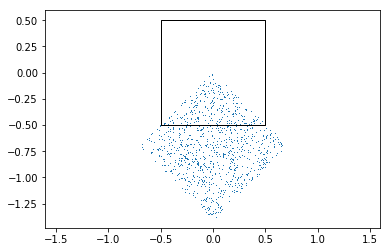

In [78]:
# test
N = 1000
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = np.random.rand(N, 3) + np.array((10, 0, 0))

angles = (np.pi/2, 0, np.pi/4)
offset = (0, np.sqrt(2), 0)
width, height = 1, 1

mask, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

plt.plot(in_plane_uv[:, 0], in_plane_uv[:, 1], ',')
plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
         [-height/2, -height/2, height/2, height/2, -height/2], '-', color='black', linewidth=1)
plt.axis('equal');

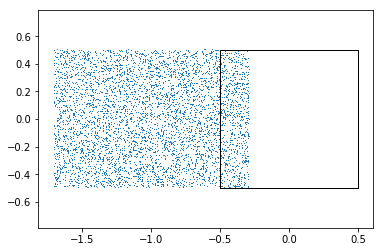

In [181]:
# test 2
N = 5000
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = np.random.rand(N, 3)-0.5 + np.array((10, 0, 0))

angles = (np.pi/4, 0, 0)
offset = (0, 0, -1)
width, height = 1, 1

mask, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

plt.plot(in_plane_uv[:, 0], in_plane_uv[:, 1], ',')
plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
         [-height/2, -height/2, height/2, height/2, -height/2], '-', color='black', linewidth=1)
plt.axis('equal');

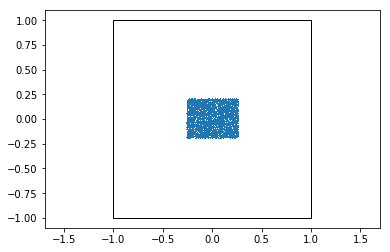

In [195]:
# test
theta = 50 *np.pi/180
deuxtheta = 2*theta

N = 5100
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = 0.4*(np.random.rand(N, 3)-0.5) + np.array((10, 0, 0))

gamma = np.pi * (np.random.rand(N,) - 0.5)

# sample
angles = (theta, 0, 0)
offset = (0, 0, 0)
width, height = 2, 2

mask, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

plt.plot(in_plane_uv[:, 0], in_plane_uv[:, 1], ',')
plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
         [-height/2, -height/2, height/2, height/2, -height/2], '-', color='black', linewidth=1)
plt.axis('equal');

In [196]:
# Diffracted directions

ref_plane_normal = np.array((.0, 1., .0))

u = normalize(u)
ref_plane_normal = normalize(ref_plane_normal)

# Define a new base with u
gamma_zero = np.cross(ref_plane_normal, u)
gamma_90 = np.cross(u, gamma_zero)

# diffracted direction:
tan_theta = np.tan(theta)
d = u + np.tan(theta)*(gamma_zero*np.cos(gamma)[:, np.newaxis] + \
                       gamma_90*np.sin(gamma)[:, np.newaxis])

In [223]:
# Detector
R_gonio = 200 # mm
width, height = 10, 10 # mm

angles = (deuxtheta + np.pi/2, 0, 0) # omega, phi, psi
offset = (0, 0, -R_gonio)

mask, uv_detector, C = rectangle_intersection(A, u, angles, offset, width, height)

In [225]:
deuxtheta *180/np.pi

100.0

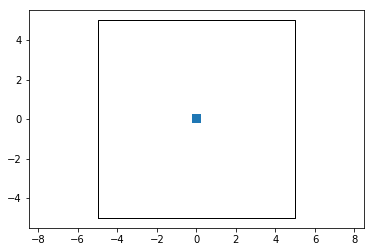

In [222]:
plt.plot(uv_detector[:, 0], uv_detector[:, 1], ',')
plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
         [-height/2, -height/2, height/2, height/2, -height/2], '-', color='black', linewidth=1)
plt.axis('equal');

In [218]:
uv_detector

array([[ 369.29197549, -292.36685833],
       [2181.11802774, 2451.88359209],
       [ 340.66172097,  250.63132328],
       ...,
       [ 318.54011061, -216.47331475],
       [ 265.96166515, -119.31349611],
       [ 261.16230023, -107.58459533]])

In [157]:
%%timeit
omega, psi, phi = np.pi/2, 0, 0
R = rotation_matrix(omega, psi, phi)

7.12 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [158]:
R

NameError: name 'R' is not defined

In [120]:
N = 10
u = np.random.rand(N, 3)
A = np.random.rand(N, 3)

In [123]:
# test
u = np.array([[-1, 0, 0], ])
A = np.array([[10, 0, 0], ])

change_base(A, u, (np.pi/2, 0, 0), (0, 0, 0))

(array([[6.123234e-16, 0.000000e+00, 1.000000e+01]]),
 array([[-6.123234e-17,  0.000000e+00, -1.000000e+00]]))

In [230]:
import numpy as np
import numpy.ma as ma

In [256]:
y = ma.array([1.0,]*N, mask = [1, ]*(N-1)+[0, ])

In [257]:
%%timeit
s = y.sum()

23.9 µs ± 344 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [258]:
y.sum()

1.0

In [259]:
y = np.array([np.NaN,]*N+[1, ])

In [260]:
%%timeit
np.nansum(y)

21.5 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [261]:
np.nansum(y)

1.0

$$\Large
\frac{\epsilon}{\varepsilon_{applied}} \propto \frac{E_{substrate}}{E_{film}} \frac{L}{h}
$$

$$\Large
Force \propto E_{substrate}\,H + E_{film}\,h
$$

$$\large
\epsilon = \varepsilon_{applied}
$$